# Проект. Анализ приложения Procrastinate Pro+ и причин снижения окупаемости

-----

## Описание проекта    
Задача — разобраться в причинах снижения ROI и помочь компании выйти в плюс.
    
**Вводные:**
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Задача детально:**
- изучить откуда приходят пользователи и какими устройствами они пользуются,
- посчитать сколько стоит привлечение пользователей из различных рекламных каналов;
- посчитать сколько денег приносит каждый клиент,
- посчитать когда расходы на привлечение клиента окупаются,
- понять какие факторы мешают привлечению клиентов.

### План работы
1. Изучить данные, понять их структуру и очистить от мусора.
2. Сделать EDA, построить графики и диаграммы, выявить закономерности.
3. Проанализировать результаты маркетинговых кампаний: CAC, расходы
4. Проанализировать поведение пользователей: LTV, ROI, retention rate
5. Сделать выводы и рекомендации

## Шаг 1. Изучение данных

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns



# Загрузка и чтение файлов
sessions = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

# Проверка первых строк каждого датасета для оценки структуры данных
#display(sessions.head(), orders.head(), costs.head())

# Проверка на наличие пропусков в данных
missing_values = {
    "sessions": sessions.isnull().sum(),
    "orders": orders.isnull().sum(),
    "costs": costs.isnull().sum()
}

# Проверка на наличие дубликатов
duplicates = {
    "sessions": sessions.duplicated().sum(),
    "orders": orders.duplicated().sum(),
    "costs": costs.duplicated().sum()
}

# Проверка типов данных в каждом датасете
data_types = {
    "sessions": sessions.dtypes,
    "orders": orders.dtypes,
    "costs": costs.dtypes
}

sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
sessions['Session End'] = pd.to_datetime(sessions['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Переименование колонок для таблицы costs
costs.rename(columns={'dt': 'dt', 'Channel': 'channel', 'costs': 'costs'}, inplace=True)

# Переименование колонок для таблицы visits
sessions.rename(columns={
    'User Id': 'user_id', 
    'Region': 'region', 
    'Device': 'device', 
    'Channel': 'channel', 
    'Session Start': 'session_start', 
    'Session End': 'session_end'
}, inplace=True)

# Переименование колонок для таблицы orders
orders.rename(columns={
    'User Id': 'user_id', 
    'Event Dt': 'event_dt', 
    'Revenue': 'revenue'
}, inplace=True)

display(sessions.info(), orders.info(), costs.info())
display(sessions.head(), orders.head(), costs.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

None

None

None

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<div class="alert alert-secondary"> 
Привели в форматы даты все столбцы, которые её содержали. Проверили на пропуски: пропусков нет.
</div>

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [51]:
#функция для получения профилей пользователей
# ---
# ### Функция: get_profiles
# Формирует таблицу профилей пользователей на основе сессий.
#
# **Вход:** 
# - `sessions` — DataFrame с колонками `user_id`, `session_start`, `channel`
#
# **Выход:** 
# - DataFrame с уникальными пользователями и полями:
#   - `first_ts` — первое посещение
#   - `channel` — источник привлечения
#   - `dt` — дата первого визита (без времени)
#   - `month` — месяц первого визита (начала месяца, для когортного анализа)
# ---

def get_profiles(sessions):

    
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()


    return profiles

In [ ]:
# ---
# ### Функция: get_retention
# Строит таблицу удержания пользователей (retention) по когортам.
#
# **Вход:**
# - `profiles` — DataFrame с профилями пользователей (`user_id`, `first_ts`, `dt`)
# - `sessions` — DataFrame с сессиями (`user_id`, `session_start`)
# - `observation_date` — дата наблюдения
# - `horizon_days` — горизонт анализа в днях (макс. lifetime)
# - `ignore_horizon` — если True, не ограничивает когорты по горизонту
#
# **Выход:**
# - `result_raw` — «сырые» данные для проверки
# - `result_grouped` — таблица удержания: строки — когорты (по `dt`), столбцы — дни удержания
# ---


# функция для расчёта ретеншна 
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    # добавляем столбец с первым посещением
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    #считаем лайфтайм
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # считаем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    #считаем количество пользователей в каждой когорте
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    #клеим размеры когорт к таблице удержания
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    #Делим каждую строку (когорту) на её размер
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

In [ ]:
# ---
# ### Функция: get_conversion
# Строит таблицы конверсии в первую покупку: по когортам, по времени и выбранным срезам.
#
# **Вход:**
# - `profiles` — DataFrame с профилями пользователей (`user_id`, `first_ts`, `dt`)
# - `purchases` — DataFrame с покупками (`user_id`, `event_dt`)
# - `observation_date` — дата наблюдения
# - `horizon_days` — горизонт анализа (макс. lifetime)
# - `dimensions` — список признаков для группировки (по умолчанию: все пользователи)
# - `ignore_horizon` — если True, включает всех пользователей независимо от горизонта
#
# **Выход:**
# - `result_raw` — объединённые данные с лайфтаймом и первой покупкой
# - `result_grouped` — таблица накопленной конверсии по когортам и `dimensions`
# - `result_in_time` — динамика конверсии по дням привлечения (`dt`)

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
# ---
# ### Функция: get_ltv
# Вычисляет LTV (Lifetime Value) и ROI (окупаемость вложений) по когортам и выбранным признакам.
#
# **Вход:**
# - `profiles` — DataFrame с профилями пользователей (`user_id`, `first_ts`, `dt`, `acquisition_cost`)
# - `purchases` — DataFrame с покупками (`user_id`, `event_dt`, `revenue`)
# - `observation_date` — дата анализа
# - `horizon_days` — горизонт анализа (в днях)
# - `dimensions` — список признаков для группировки (например, канал, устройство)
# - `ignore_horizon` — если True, включает пользователей, не достигших горизонта
#
# **Выход:**
# - `result_raw` — объединённые сырые данные
# - `result_grouped` — таблица LTV по когортам/срезам
# - `result_in_time` — LTV по датам привлечения (`dt`)
# - `roi_grouped` — таблица ROI по когортам/срезам
# - `roi_in_time` — ROI по датам привлечения (`dt`)


def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [32]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [33]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [34]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [35]:
# функция для визуализации LTV и ROI


def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Шаг 2. Исследовательский анализ данных

- Составляем профили пользователей. Определяем минимальную и максимальную даты привлечения пользователей.
- Выясняем, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
- Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Исследовать рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей.


Составляем профили пользователей. Определяем минимальную и максимальную даты привлечения пользователей.Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.↓

In [36]:
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()


    return profiles

profiles = get_profiles(sessions)

# Определение минимальной и максимальной дат привлечения пользователей
min_acquisition_date = profiles['dt'].min()
max_acquisition_date = profiles['dt'].max()


display(profiles, min_acquisition_date, max_acquisition_date)

,user_id,first_ts,channel,dt,month
0,599326,2019-05-07 20:58:57,FaceBoom,2019-05-07,2019-05-01
1,4919697,2019-07-09 12:46:07,FaceBoom,2019-07-09,2019-07-01
2,6085896,2019-10-01 09:58:33,organic,2019-10-01,2019-10-01
3,22593348,2019-08-22 21:35:48,AdNonSense,2019-08-22,2019-08-01
4,31989216,2019-10-02 00:07:44,YRabbit,2019-10-02,2019-10-01
...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,2019-09-28,2019-09-01
150004,999975439887,2019-10-21 00:35:17,organic,2019-10-21,2019-10-01
150005,999976332130,2019-07-23 02:57:06,TipTop,2019-07-23,2019-07-01
150006,999979924135,2019-09-28 21:28:09,MediaTornado,2019-09-28,2019-09-01


datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

<div class="alert alert-secondary"> 
Вывод: 

- мин дата привлечения: 2019-05-01
- макс дата привлечения: 2019-10-27
</div>

Выясняем, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.


In [37]:
# Добавление информации о том, является ли пользователь платящим
profiles['is_payer'] = profiles['user_id'].isin(orders['user_id'])

# Объединение профилей с сессиями для получения информации о странах
profiles_with_region = profiles.merge(sessions[['user_id', 'region']].drop_duplicates(), on='user_id', how='left')

# Подсчёт количества пользователей и платящих пользователей по странам
users_by_country = profiles_with_region.groupby('region').agg(
    total_users=('user_id', 'count'),
    paying_users=('is_payer', 'sum')
).reset_index()

# Расчёт доли платящих пользователей
users_by_country['paying_share'] = users_by_country['paying_users'] / users_by_country['total_users']

# Сортировка по количеству платящих пользователей
users_by_country.sort_values(by='paying_users', ascending=False, inplace=True)

users_by_country


,region,total_users,paying_users,paying_share
3,United States,100002,6902,0.069019
2,UK,17575,700,0.039829
0,France,17450,663,0.037994
1,Germany,14981,616,0.041119


<div class="alert alert-secondary"> 
  
Выводы:
- основная доля пользователей из США. Из 100к пользователей Доля платящих - 7%, это 6902 в абсолюте. 
- В Британии доля платящих - 4%, с абсолютом 700 платящих
</div>

Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [38]:
# Объединение профилей с сессиями для получения информации об устройствах
profiles_with_device = profiles.merge(sessions[['user_id', 'device']].drop_duplicates(), on='user_id', how='left')

# Подсчёт количества пользователей и платящих пользователей по устройствам
users_by_device = profiles_with_device.groupby('device').agg(
    total_users=('user_id', 'count'),
    paying_users=('is_payer', 'sum')
).reset_index()

# Расчёт доли платящих пользователей
users_by_device['paying_share'] = users_by_device['paying_users'] / users_by_device['total_users']

# Сортировка по количеству платящих пользователей
users_by_device.sort_values(by='paying_users', ascending=False, inplace=True)

users_by_device


,device,total_users,paying_users,paying_share
3,iPhone,55798,3768,0.067529
0,Android,36377,2458,0.067570
1,Mac,31335,2346,0.074868
2,PC,31681,1947,0.061456


<div class="alert alert-secondary"> 
  
Выводы:
- На первом месте — iphone, на втором - android. С очень походими долями платящих. 
- Самая большая доля платящих у пользователей Мака
</div>

Исследовать рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей.

In [39]:
# Объединение профилей с информацией о каналах привлечения
#profiles_with_channel = profiles.merge(sessions[['user_id', 'channel']].drop_duplicates(), on='user_id', how='left')

# Подсчёт пользователей и платящих пользователей по каналам
users_by_channel = profiles.groupby('channel').agg(
    total_users=('user_id', 'nunique'),
    paying_users=('is_payer', 'sum')
).reset_index()

# Расчёт доли платящих пользователей
users_by_channel['paying_share'] = users_by_channel['paying_users'] / users_by_channel['total_users']

# Сортировка по количеству платящих пользователей
users_by_channel.sort_values(by='paying_users', ascending=False, inplace=True)

display(users_by_channel)


,channel,total_users,paying_users,paying_share
1,FaceBoom,29144,3557,0.122049
6,TipTop,19561,1878,0.096007
10,organic,56439,1160,0.020553
7,WahooNetBanner,8553,453,0.052964
0,AdNonSense,3880,440,0.113402
5,RocketSuperAds,4448,352,0.079137
2,LeapBob,8553,262,0.030633
4,OppleCreativeMedia,8605,233,0.027077
9,lambdaMediaAds,2149,225,0.104700
8,YRabbit,4312,165,0.038265


<div class="alert alert-secondary"> 
  
Выводы
Топ 3 канала: FB,TipTop, organic. Лучшая доля платящих также в FB, 12.2%. В Тик-токе доля платящих почти 10%. Низкий показатель у органики, всего 2%
</div>

## Шаг 3. Проанализировать результаты маркетинговых кампаний: CAC, расходы

- Посчитать общую сумму расходов на маркетинг.
- Посчитать сколько денег потратили на каждый источник.
- Посмотреть динамику расходов на каждый источник.
- Посчитать CAC для каждого источника.



Общая сумма расходов на маркетинг.

In [40]:
cac = costs.groupby('dt').agg({'costs':'sum'}).rename(columns={'costs':'cac'})
print(cac.sum())

cac    105497.3
dtype: float64


<div class="alert alert-secondary"> 
  
Итого потратили 105487$
</div>

Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.


In [41]:
# Подсчёт расходов по каналам
costs_by_channel = costs.groupby('channel').agg(total_costs=('costs', 'sum')).reset_index()

# Объединение таблицы пользователей по каналам с данными о расходах
users_by_channel = users_by_channel.merge(costs_by_channel, on='channel', how='left')

# Расчёт средних расходов на привлечение одного пользователя по каналу
users_by_channel['acquisition_cost'] = users_by_channel['total_costs'] / users_by_channel['total_users']

# Проверка и вывод результатов
display(users_by_channel)


,channel,total_users,paying_users,paying_share,total_costs,acquisition_cost
0,FaceBoom,29144,3557,0.122049,32445.60,1.113286
1,TipTop,19561,1878,0.096007,54751.30,2.799003
2,organic,56439,1160,0.020553,NaN,NaN
3,WahooNetBanner,8553,453,0.052964,5151.00,0.602245
4,AdNonSense,3880,440,0.113402,3911.25,1.008054
5,RocketSuperAds,4448,352,0.079137,1833.00,0.412095
6,LeapBob,8553,262,0.030633,1797.60,0.210172
7,OppleCreativeMedia,8605,233,0.027077,2151.25,0.250000
8,lambdaMediaAds,2149,225,0.104700,1557.60,0.724802
9,YRabbit,4312,165,0.038265,944.22,0.218975


**Лучшие каналы:**

- FaceBoom — самый эффективный канал. Привлёк 3557 платящих пользователей, стоимость привлечения одного пользователя составляет всего 1.11 доллара.
- AdNonSense и lambdaMediaAds — оба канала также хороши, привлекают много платящих пользователей (10% от общего числа) по разумной цене (1.01 и 0.72 доллара на пользователя).

**Самый дорогой канал:**
- TipTop — тратит много денег (2.80 доллара на пользователя), но привлекает меньше платящих пользователей по сравнению с FaceBoom, что делает его менее выгодным.

**Органический трафик:**
- organic — привлекает огромное количество пользователей (56439), но только 2% из них становятся платящими. Однако, поскольку это бесплатный канал, он выгоден для привлечения большого количества пользователей без вложений.

**Менее успешные каналы:**
- YRabbit и MediaTornado — оба канала показывают низкую эффективность: мало кто из привлеченных становится платящими пользователями, несмотря на сопоставимые затраты с другими каналами.

Посмотреть динамику расходов на каждый источник.

In [43]:
#группируем расходы на неделям и по месяцам в разбивке источников
costs['month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
cost_pivot_month = costs.pivot_table(index='channel',columns = 'month', values='costs',aggfunc='sum')

costs['week'] = costs['dt'].dt.to_period('W').dt.to_timestamp()

cost_pivot_week = costs.pivot_table(index='channel',columns = 'week', values='costs',aggfunc='sum')

display(cost_pivot_month)
display(cost_pivot_week)




month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,1169.70,538.650,504.00,579.60,581.70,537.600
FaceBoom,3524.40,5501.100,5294.30,6274.40,6114.90,5736.500
LeapBob,140.28,314.580,313.53,369.81,343.98,315.420
MediaTornado,238.56,138.000,138.48,154.56,144.72,140.160
OppleCreativeMedia,169.75,370.000,366.50,439.25,427.75,378.000
RocketSuperAds,577.98,325.715,252.07,253.11,218.40,205.725
TipTop,2981.00,6675.600,8410.20,11202.00,13232.50,12250.000
WahooNetBanner,418.80,921.000,851.40,1040.40,977.40,942.000
YRabbit,299.70,106.200,97.38,124.74,152.79,163.410


week,2019-04-29,2019-05-06,2019-05-13,2019-05-20,2019-05-27,2019-06-03,2019-06-10,2019-06-17,2019-06-24,2019-07-01,...,2019-08-19,2019-08-26,2019-09-02,2019-09-09,2019-09-16,2019-09-23,2019-09-30,2019-10-07,2019-10-14,2019-10-21
channel,,,,,,,,,,,,,,,,,,,,,
AdNonSense,211.05,273.00,265.65,266.70,202.650,102.90,96.60,141.75,148.05,130.200,...,142.80,133.35,100.800,100.80,139.650,192.15,155.40,136.500,118.650,154.35
FaceBoom,535.70,750.20,755.70,722.70,1208.900,1081.30,1042.80,1280.40,1647.80,1536.700,...,1411.30,1445.40,1151.700,1148.40,1496.000,1837.00,1761.10,1392.600,1291.400,1552.10
LeapBob,16.80,31.71,26.67,26.67,65.520,66.99,52.29,68.46,99.75,87.360,...,90.51,77.91,66.990,63.84,81.270,101.22,101.01,78.960,69.720,84.42
MediaTornado,38.64,61.68,59.04,50.16,36.960,27.60,29.76,32.16,40.56,43.440,...,35.28,33.84,30.240,25.92,30.240,48.24,42.00,36.960,29.040,37.44
OppleCreativeMedia,24.00,34.50,27.50,34.25,81.750,79.50,71.50,79.75,107.00,102.500,...,103.75,92.75,72.750,78.00,105.750,132.25,123.00,88.250,88.000,101.50
RocketSuperAds,99.45,139.23,138.06,131.04,97.695,76.05,63.18,80.73,78.26,75.075,...,40.30,51.35,40.625,40.95,56.225,63.70,66.30,51.675,46.475,50.70
TipTop,347.00,470.00,454.00,801.80,1421.200,1223.60,1121.00,1474.40,2343.60,2340.000,...,2514.00,2583.00,2563.000,2506.00,3241.000,3979.50,3703.00,3097.500,2737.000,3265.50
WahooNetBanner,49.20,92.40,90.00,79.20,179.400,196.80,166.20,201.60,285.00,256.800,...,244.80,235.80,174.600,192.60,226.200,303.00,309.00,208.800,216.000,253.20
YRabbit,52.20,75.90,69.30,65.40,49.800,25.80,17.46,22.14,27.90,28.260,...,30.03,24.36,27.930,29.76,39.600,47.52,45.36,38.310,36.450,48.33


/var/folders/sw/s79qgq9x1nx8w18w3nzs_r1r0000gn/T/ipykernel_34513/802771933.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))


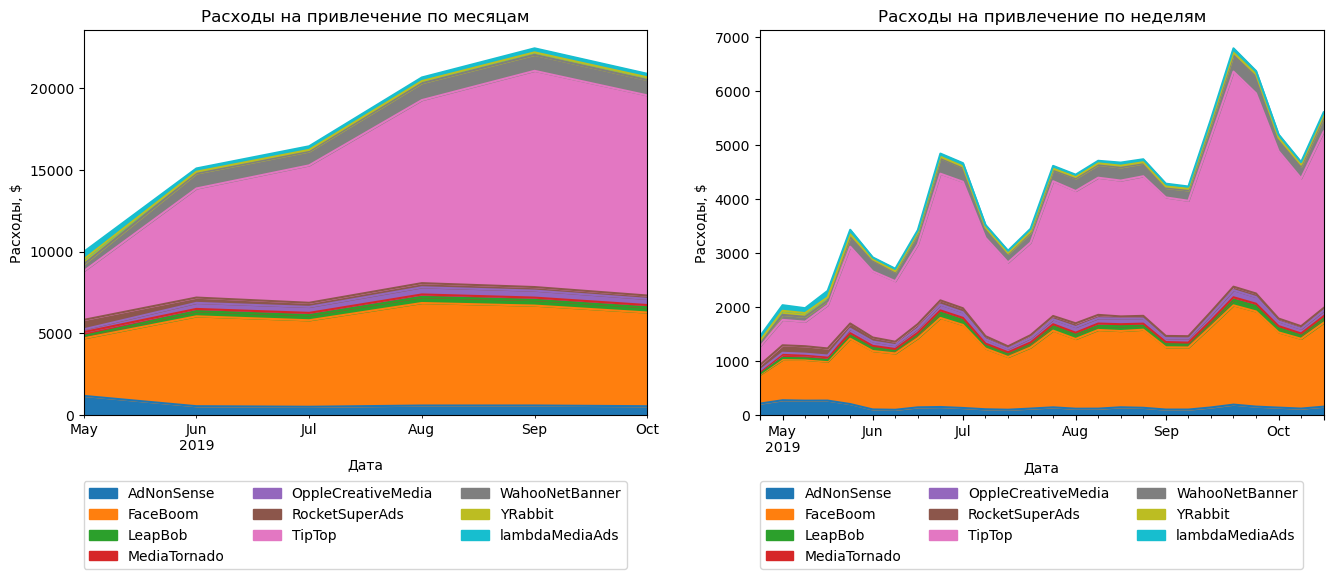

In [46]:


costs['Расходы на привлечение по месяцам'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
costs['Расходы на привлечение по неделям'] = costs['dt'].dt.to_period('W').dt.to_timestamp()

columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

plt.subplots(figsize = (16, 5))
for i, col in enumerate(columns):
    costs.pivot_table(index = col, columns = 'channel', values = 'costs', 
                      aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
    plt.legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left', borderaxespad=0)
plt.show()

<div class="alert alert-secondary"> 
  
Вывод:
- В начале мая Тикток был меньше чем ФБ по расходам. К октябрю канал вырос до 12к, опередив ФБ в 2 раза. Последнюю неделю оба канала снижаются
</div>

Посчитайте CAC для каждого источника.

In [48]:
def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # преобразуем dt в costs к datetime, чтобы соответствовать типу в profiles
    costs['dt'] = pd.to_datetime(costs['dt']).dt.date

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

profiles = get_profiles(sessions, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [49]:
cac_by_channel = profiles.groupby('channel')['acquisition_cost'].mean().reset_index()

# переименуем колонки для лучшей интерпретируемости
cac_by_channel.rename(columns={'acquisition_cost': 'average_cac'}, inplace=True)

# Вывод результата
display(cac_by_channel.sort_values(by='average_cac',ascending=False))


,channel,average_cac
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


In [50]:
# Преобразование дат к формату datetime и создание нового столбца 'month'
costs['dt'] = pd.to_datetime(costs['dt'])
profiles['dt'] = pd.to_datetime(profiles['dt'])

# Создание колонки 'month' для группировки по ним
costs['month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
profiles['month'] = profiles['dt'].dt.to_period('M').dt.to_timestamp()

# Группировка данных по месяцам
total_cost = costs.groupby('month').agg({'costs':'sum'}).rename(columns={'costs':'total_costs'})
cohort_size = profiles.groupby('month').agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})

# Объединение данных по месяцам
cac = total_cost.merge(cohort_size, on='month', how='left').fillna(0)

# Вычисление CAC
cac['cac'] = cac['total_costs'] / cac['cohort_size']

# Вывод результирующего DataFrame
display(cac)

,total_costs,cohort_size,cac
month,,,
2019-05-01,9978.570,27111,0.368064
2019-06-01,15090.045,23123,0.652599
2019-07-01,16447.060,22627,0.726878
2019-08-01,20657.870,26586,0.777021
2019-09-01,22441.340,26327,0.852408
2019-10-01,20882.415,24234,0.861699


<div class="alert alert-secondary"> 
  
Вывод: 
- Средний CAC с Тиктока = 2.8$, FB = 1.1, Adnonsense = 1
- CAC сильно подрос в когортах с 07 месяца. Признак прямого виляния увеличения бюджета в Тиктоке
</div>

## Шаг 4. Проанализировать поведение пользователей: LTV, ROI, retention rate

Считаем, что на календаре 1 ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Исключаем органику.

In [23]:

profiles = profiles
purchases = orders
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14



In [24]:
profiles = profiles.query('channel != "organic"')

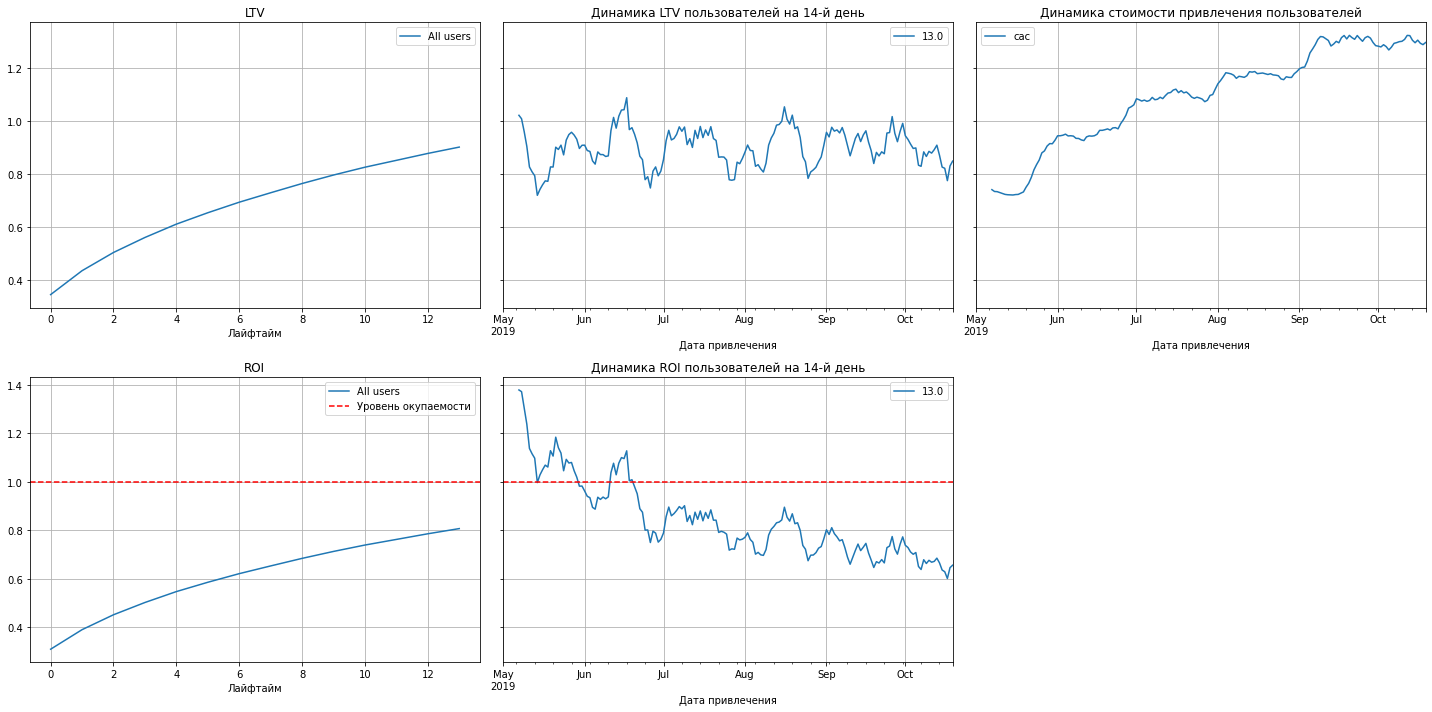

In [25]:
# считаем LTV и ROI без органики
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-secondary"> 
  
Вывод: 
- ЛТВ на 14 день меньше 1$
- Динамика ЛТВ на 14 день колеблится в районе 0.8-1
- Динамика CAC стабильно растёт с середины мая и до сентября, после чего переходит в плато.
- ROI не окупается на 14 день и доходит до 0.8
- Динамика ROI на 14 день тоже нисходящая. С конца мая идет снижение 
</div>

In [26]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):    
    
       # Фильтрация данных для исключения органических пользователей
    #ltv_history = ltv_history[ltv_history['channel'] != 'organic']
   #roi_history = roi_history[roi_history['channel'] != 'organic']
    
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Исследовать конверсию

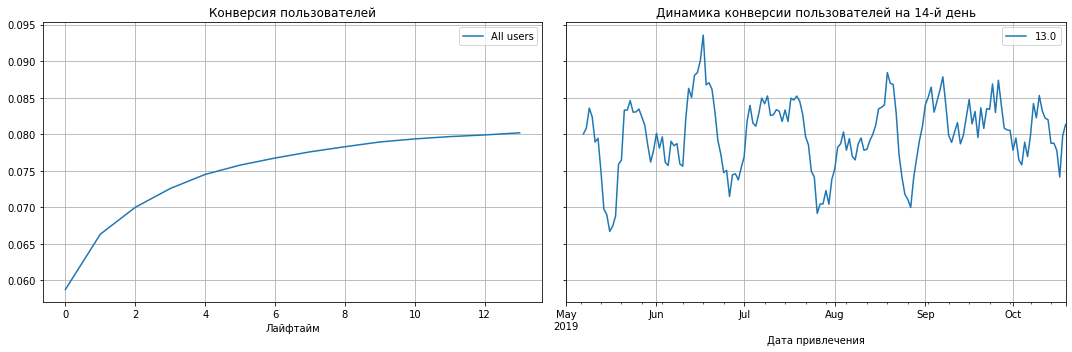

In [27]:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=[]
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


<div class="alert alert-secondary"> 
  
Вывод:
- Конверсия не растёт быстро, но имеет тенденцию к стабильному повышению, что может быть хорошим знаком для долгосрочного роста базы платящих пользователей.
- Конверсия на 14 день выросла с конца мая. Имеет сильные колебания.
</div>

Анализ окупаемости рекламы с разбивкой по устройствам.

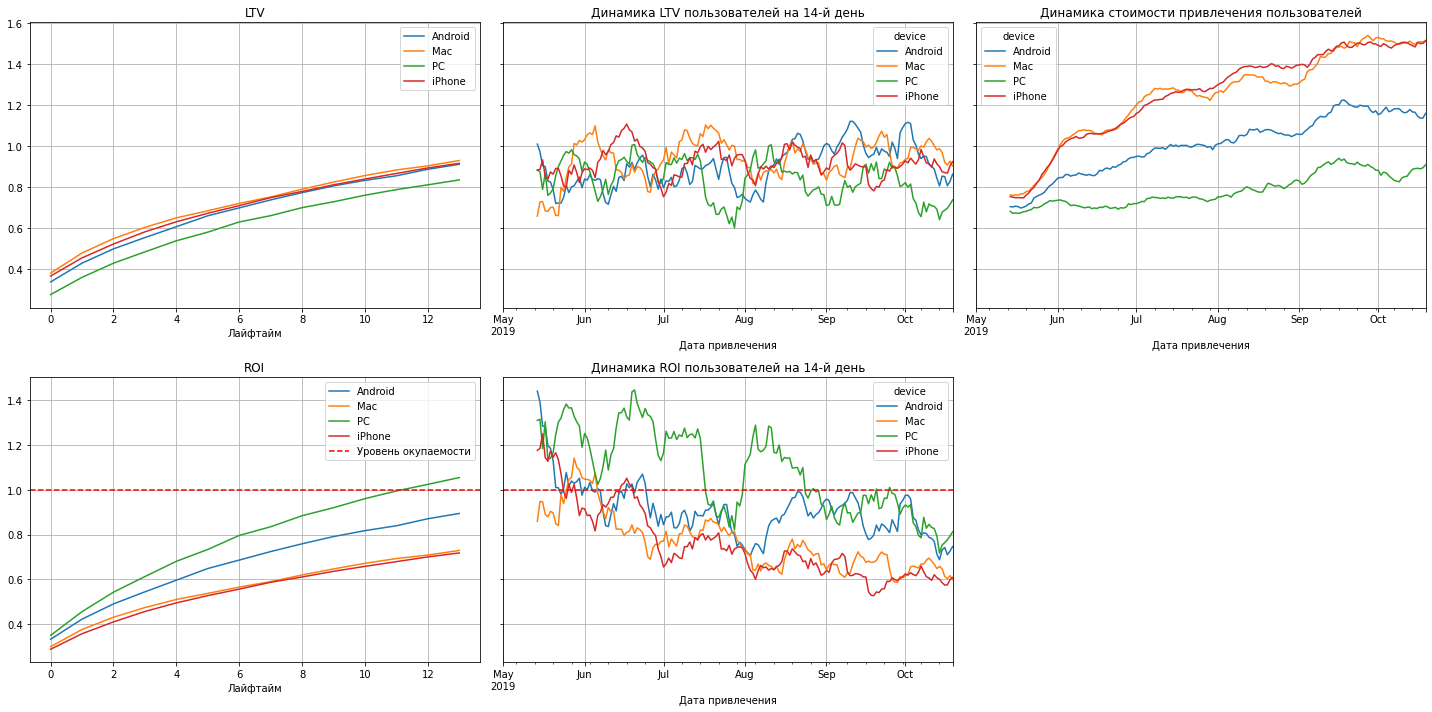

In [28]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

<div class="alert alert-secondary"> 
  
Вывод: 
- топовое устройство по ROI - Android из-за низкой стоимости привлечения по сравнению с Iphone. Динамика ЛТВ у всех девайсов похожая. 
- Владельцы Андройд выходят в плюс с 7 дня ЛТ, а пользователи iphone - не выходят в плюс. Можем заметить, что все снижаются на 14 по ROI. Айфон и мак переходят минусовую отметку в июле. Андройд переходит в минус только в октябре. Но в целом, также падал в июне.
</div>

Анализ окупаемости рекламы с разбивкой по странам.

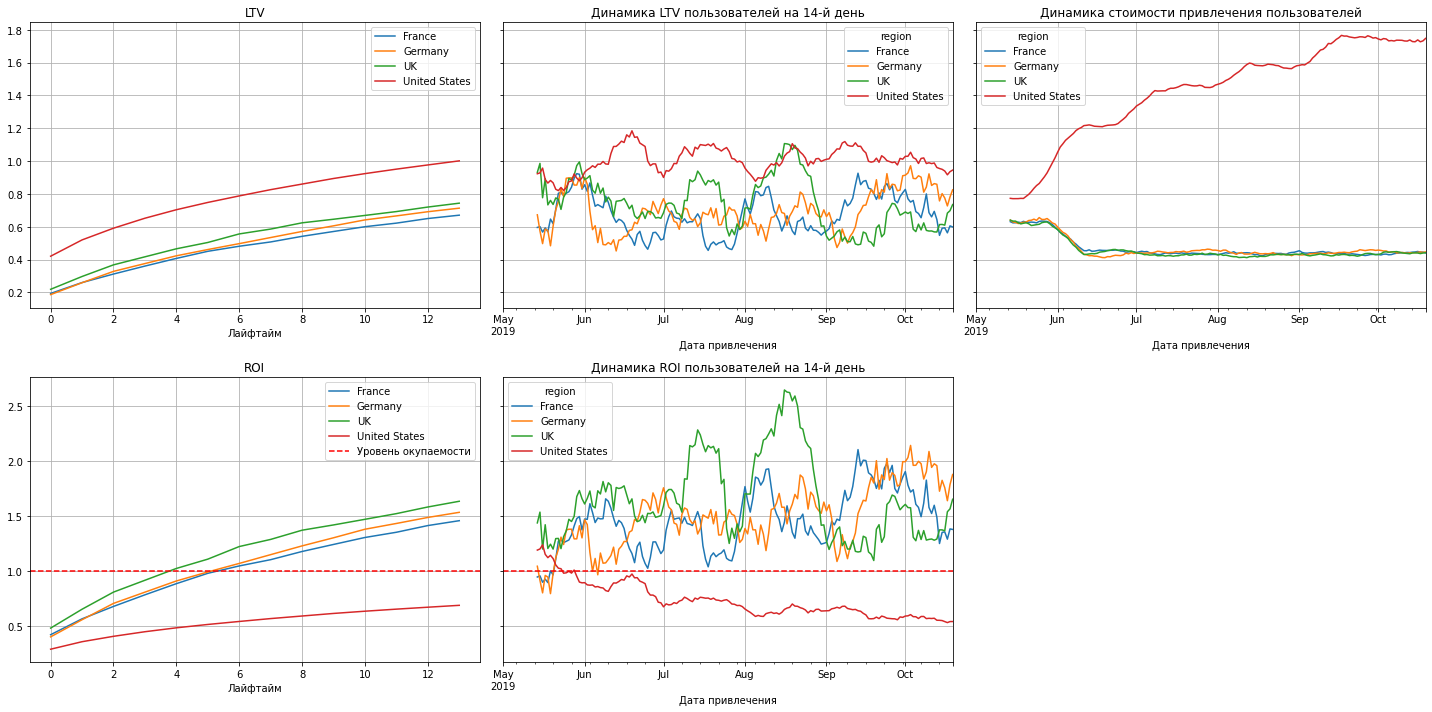

In [29]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

<div class="alert alert-secondary"> 
  
Вывод: 
- Топ по ЛТВ - США. В США самая стабильная динамика ЛТВ на 14 день. Но в то же время в США сильно началася рост цены привлечения: с конца марта и середины июня месяца идёт сильный рост повышения цены. Похоже на то, что Тикток запускали на США, и поэтому CAC так сильно растёт.
        
- В то же время ROI пользователей из США - не доходит до окупаемости за 14 дней. Пользователи из Европейских стран начинают окупаться уже со второго-третьего дня. Также можем наблюдать, как сильно падает динамика ROI на 14 день в штатах. С июня месяца. В остальных странах она остается на прежнем уровне и всегда в плюсе.
</div>

Анализ окупаемости рекламы с разбивкой по рекламным каналам

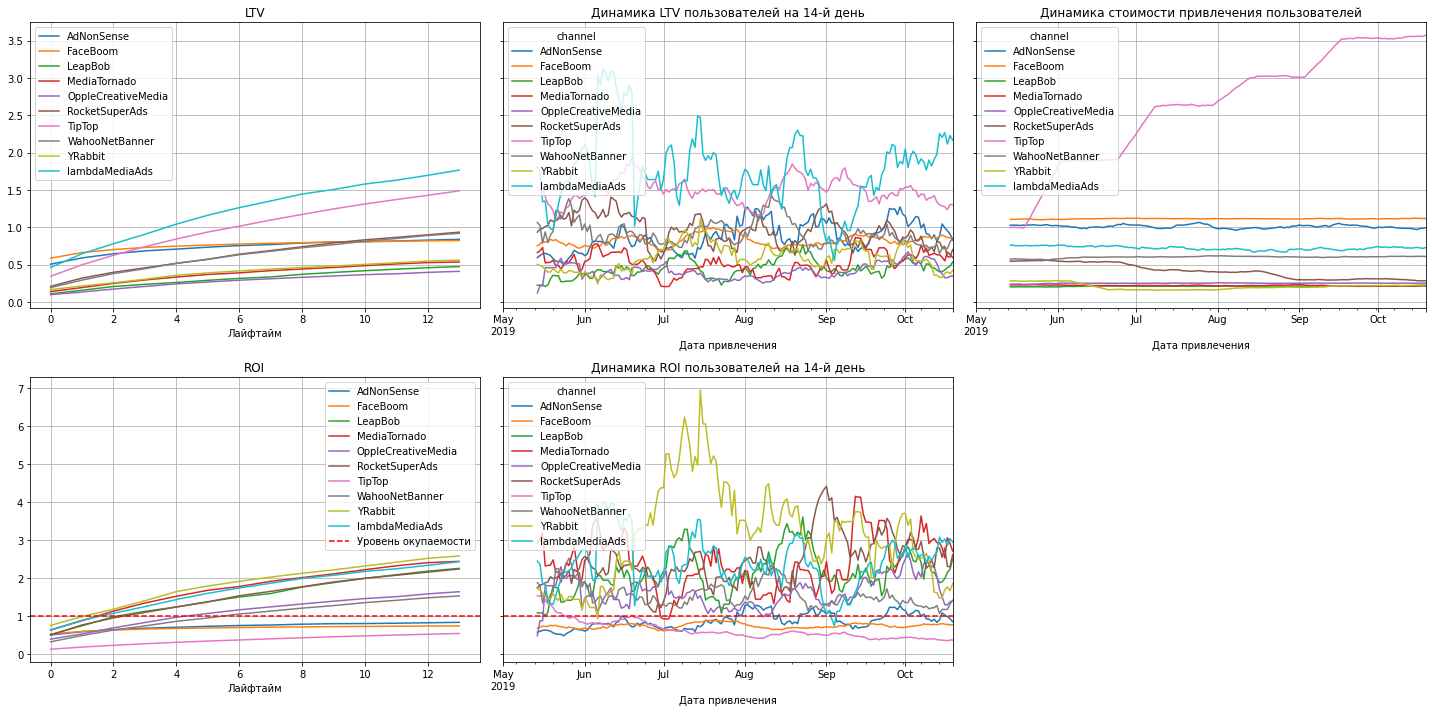

In [30]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

<div class="alert alert-secondary"> 
  
Выводы:
По графику динамики CAC можно увидеть, как кратно растёт канал Тиктока. 
В среднем реклама не окупается, и на 14 день выходит в 0.9 ROI. США сильно аффектит окупаемость привлечения. Также пользователи Iphone и Mac.  

Проблема находится в США в канале Тикток, который начал кратно увеличивать CAC. С середины мая- начала июня.
TipTop - очень дорогой канал, тянущий деньги. FaceBoom приводит платящих пользователей с низким качеством, они быстро уходят. В этом можно и нужно убедиться, построив графики конверсии и удержания по всем каналам
</div>

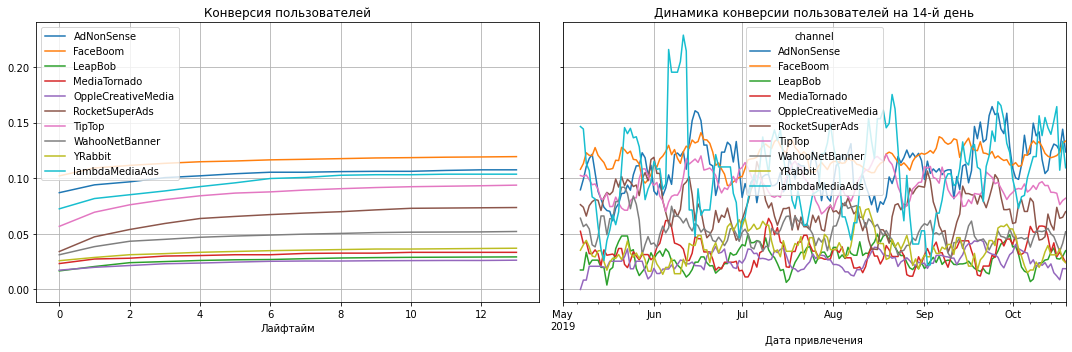

In [31]:
#графики конверсии
dimension = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimension
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

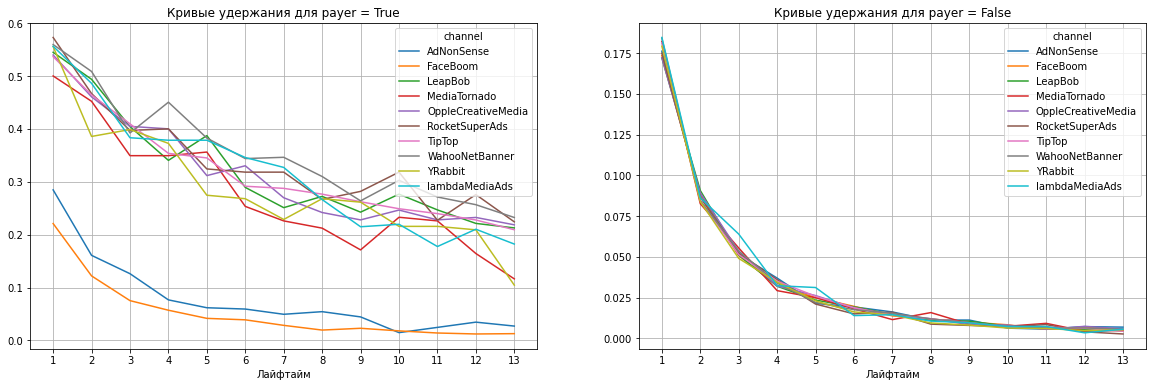

In [32]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


observation_date = profiles['dt'].max()

analysis_horizon = 14

retention_raw, retention = get_retention(
    profiles, sessions, observation_date, analysis_horizon, dimensions=['channel']
)

report = retention.drop(columns=['cohort_size', 0])

plt.figure(figsize=(20, 6))

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))
plt.show()

<div class="alert alert-secondary"> 
Вывод:
ФБ и ADNonsesne удерживают кратно хуже чем остальные каналы трафика
</div>

## Шаг 5. Выводы и рекомендации

#### Причины неэффективности

- **Низкое качество трафика с TikTok**  
  Высокая стоимость привлечения при низком ROI может свидетельствовать о нецелевой аудитории.

- **Пользователи с iOS не достигают окупаемости**  
  Рекомендуется отдельно проанализировать кампании, ориентированные на устройства Apple.

- **Отсутствие оптимизации рекламных кампаний**  
  Нехватка A/B тестирования и обновления креативов снижает эффективность рекламы.

- **Слабая стратегия удержания**  
  Недостаток коммуникации с пользователями после привлечения ведёт к их быстрой потере и снижению LTV.



#### Рекомендации

1. **Анализ целевой аудитории TikTok**  
   Убедитесь, что кампания таргетирует подходящую аудиторию. В противном случае — рассмотреть отключение канала.

2. **A/B тестирование**  
   Протестировать рекламные сообщения и лендинги для повышения конверсии.

3. **Перераспределение бюджета**  
   Аллоцировать больше средств в Facebook, Google Ads и другие каналы с положительным ROI на ранних этапах.

4. **Улучшение удержания (особенно для США)**  
   - Персонализированный UX  
   - Email- и push-рассылки  
   - Персональные рекомендации  
   - Система наград и привилегий для постоянных пользователей  

5. **Оптимизация работы с Facebook**  
   - Таргетинг на пользователей с высокой склонностью к оплате  
   - Поощрение за репосты и социальную активность, связанную с приложением
